<a href="https://colab.research.google.com/github/aranpandey/Temp-Mortality-Analysis/blob/main/Temp_Mortality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as st
from datetime import datetime
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import random
import tensorflow as tf



In [ ]:
import pandas as pd
#df = ! wget https://www.ncei.noaa.gov/pub/data/cirs/climdiv/climdiv-tmaxst-v1.0.0-20230406
#df_tmin=https://www.ncei.noaa.gov/data/climdiv/access/climdiv-tminst-v1.0.0-20230406

# Read the weird file format based on readme
def readfileName(fileName, stateCode):
  colspecs = [(0, 10), (11, 17), (18, 24), (25, 31), (32, 38), (39, 45), (46,52), (53,59), (60,66), (67,73), (74,80), (81,87), (88,94)]
  colnames = ['metainfo', '01', '02', '03','04','05','06','07','08','09','10','11','12']
  df = pd.read_fwf(fileName, colspecs=colspecs, names=colnames, converters = {'metainfo':lambda x : str(x)})
  df['stateCode'] = df['metainfo'].str[:3]
  df['Year'] = df['metainfo'].str[6:10]
  df = df[(df['stateCode'] == '110')]

  return df


  #Upper/lower bound for TMaX
def classifyIfInRange(row):
    if row['tmax'] < row['ci_low']:
       return 1
    elif row['tmax'] >row['ci_high']:
        return 1
    else:
     return 0

#Calculate confidence interval
def mean_confidence_interval(df_small, confidence=0.90):
    m=df_small['tmax'].mean()
    se=st.sem(df_small['tmax'] )
    h=st.norm.interval(0.90,m,se)

    return m, h

#This function calculates the mean and confidence interval for each week of the year. That is for 52 weeks.
def populate_weekly_confidence(base_data,all_data):
    #loop through each record to find mean confidence interval for each row
    for i in range(1, 53):
       df_week= base_data [(base_data['Week'] ==i)]
       upper_alt=mean_confidence_interval(df_week)
       all_data.loc[all_data['Week'] == i, 'ci_low'] = upper_alt[1][0]
       all_data.loc[all_data['Week'] == i, 'ci_high'] = upper_alt[1][1]

#This function calculates the mean and confidence interval for each month of the year.
def populate_monthly_confidence(base_data,all_data):
    for i in range(1, 13):
       df_month= base_data [(base_data['month'] ==i)]
       upper_alt=mean_confidence_interval(df_month)
       all_data.loc[all_data['month'] == i, 'ci_low'] = upper_alt[1][0]
       all_data.loc[all_data['month'] == i, 'ci_high'] = upper_alt[1][1]







In [ ]:
#Use base data - upto 1999 to calculate confidence interval. Using the confidence interval find EHE count for each year

#readfileName('https://www.ncei.noaa.gov/pub/data/cirs/climdiv/climdiv-tmaxst-v1.0.0-20230406', '110')
!wget  https://github.com/aranpandey/CornyWebbedRegisters/raw/master/climdiv-tmaxst-v1.0.0-20230406

df = readfileName('climdiv-tmaxst-v1.0.0-20230406', '110')


df.head()
df = df.melt(['metainfo','stateCode','Year'],var_name = 'month', value_name = 'tmax')
df['month'] = df['month'].astype(int)
df['Year'] = df['Year'].astype(int)
df.head()

base_data = df[(df['Year'] <= 1999)]
base_data.tail()

print(df.head())

populate_monthly_confidence(base_data,df)

df["EHE"] = df.apply(lambda row: classifyIfInRange(row), axis=1)
df.head()

df_w = df.groupby('Year')['EHE'].sum().reset_index()
df_w2 = df.groupby('Year')['tmax'].mean().reset_index()
df_w = pd.merge(df_w, df_w2, on = 'Year')

df_w.head()




--2023-08-04 19:44:14--  https://github.com/aranpandey/CornyWebbedRegisters/raw/master/climdiv-tmaxst-v1.0.0-20230406
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/aranpandey/CornyWebbedRegisters/master/climdiv-tmaxst-v1.0.0-20230406 [following]
--2023-08-04 19:44:15--  https://raw.githubusercontent.com/aranpandey/CornyWebbedRegisters/master/climdiv-tmaxst-v1.0.0-20230406
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1223334 (1.2M) [text/plain]
Saving to: ‘climdiv-tmaxst-v1.0.0-20230406’

climdiv-tmaxst-v1.0 100%[===================>]   1.17M  --.-KB/s    in 0.01s   

2023-08-04 19:44:15 (10

,Year,EHE,tmax
0,1895,11,62.571667
1,1896,12,63.735833
2,1897,9,63.395833
3,1898,9,63.309167
4,1899,11,62.930000


In [ ]:
#Read mortality Data

!wget https://github.com/aranpandey/CornyWebbedRegisters/raw/master/Deaths.csv
df_mor=pd.read_csv('Deaths.csv')
df_mor.head()
df_mor.columns = df_mor.columns.str.replace(' ', '')
df_mor_year = df_mor.groupby(['Year'])['Total'].sum().reset_index()
print(df_mor['Year'].agg(['min', 'max']))

df_mor_year.tail(500)
len(df_mor)
df_mor.head(1000)
df_mor['Year'] = df_mor['Year'].str.strip()
df_mor['Year'] = df_mor['Year'].str[:4]
df_mor_year = df_mor.groupby(['Year'])['Total'].sum().reset_index()

df_mor_year.head()

--2023-08-04 16:04:37--  https://github.com/aranpandey/CornyWebbedRegisters/raw/master/Deaths.csv
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/aranpandey/CornyWebbedRegisters/master/Deaths.csv [following]
--2023-08-04 16:04:37--  https://raw.githubusercontent.com/aranpandey/CornyWebbedRegisters/master/Deaths.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 930255 (908K) [text/plain]
Saving to: ‘Deaths.csv’

Deaths.csv          100%[===================>] 908.45K  --.-KB/s    in 0.02s   

2023-08-04 16:04:37 (45.9 MB/s) - ‘Deaths.csv’ saved [930255/930255]

min      1933
max    2021 9
Name: 

,Year,Total
0,1933,1342105.95
1,1934,1396903.06
2,1935,1392751.95
3,1936,1479228.21
4,1937,1450426.97


In [ ]:
#Merge EHE and mortality data on "Year"

df_mor_year['Year'] = df_mor_year['Year'].astype('int64')

df['Year'] = df['Year'].astype('int64')
df_w.astype('int64')
df_merged= pd.merge(df_mor_year, df_w, on="Year", how = 'left').reset_index()
df_merged.head(2)



,index,Year,Total,EHE,tmax
0,0,1933,1342105.95,10,65.4075
1,1,1934,1396903.06,11,66.7625


In [ ]:
#prepare features/inputs for different models

inputs = (df_merged['Total']).to_numpy()
outputs = (df_merged['Total']).to_numpy()
inputs1 = df_merged['EHE'].to_numpy()


df.tail(5)
days = []
count = 0
for elements in inputs:
  count += 1
  days.append(count)
df_merged['elapsed'] = days
df_merged.head(5)





,index,Year,Total,EHE,tmax,elapsed
0,0,1933,1342105.95,10,65.407500,1
1,1,1934,1396903.06,11,66.762500,2
2,2,1935,1392751.95,11,63.676667,3
3,3,1936,1479228.21,11,64.602500,4
4,4,1937,1450426.97,11,63.439167,5


87
18
62199.26619537361
18
0.8219373090435633
16372303208.822435
127954.30125174548


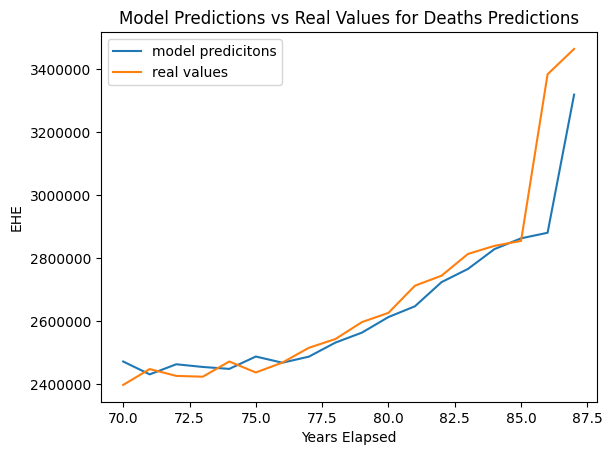

In [ ]:
#Experiment 1
#Cell is for Autoregressive Linear Regression
#Experiment 1 uses mortality to predict mortality

from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt


days=df_merged['elapsed']


past = 2
s = (len(inputs) , past  * 1)
betterinputs = np.zeros(s)
betteroutputs = np.zeros(len(inputs))

for i in range(len(inputs) - past): # - 0
  temp = np.zeros(past * 1)
  temp[0 : past] = inputs[i : i+ past]
  betterinputs[i] = temp
  betteroutputs[i] = inputs[i+past]

betterinputs = betterinputs[0:len(df_merged) - past] # - 0
betteroutputs = betteroutputs[0:len(df_merged) - past]
days = days[0:len(df_merged) - past]
print(len(days))


split = int(0.8*len(betterinputs))
X_train, X_test, y_train, y_test = betterinputs[:split], betterinputs[split:], betteroutputs[:split], betteroutputs[split:]
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
days = days[split:]
print(len(days))


model=LinearRegression()

X_train, X_test, y_train, y_test = betterinputs[:split], betterinputs[split:], betteroutputs[:split], betteroutputs[split:]
model.fit(X_train, y_train)
print("{}".format(np.linalg.norm(model.predict(X_test) - y_test, 1)/len(y_test)))
predict = model.predict(X_test)
plt.title("Model Predictions vs Real Values for Deaths Predictions")
plt.ticklabel_format(style='plain')

print(len(days))

plt.plot( days, predict, label = "model predicitons")
plt.plot( days, y_test,  label = "real values")
plt.xlabel("Years Elapsed")
plt.ylabel("EHE")
plt.legend()
cross_val_score(model, X_train, y_train, cv = 2)

from sklearn.metrics import mean_squared_error
print(model.score(X_test, y_test))
mse = mean_squared_error(y_test, predict)
print(mse)
rmse = np.sqrt(mse)
print(rmse)

87
18
81881.90270745858
18
0.7710799234732835
21048479517.80748
145080.94126317033


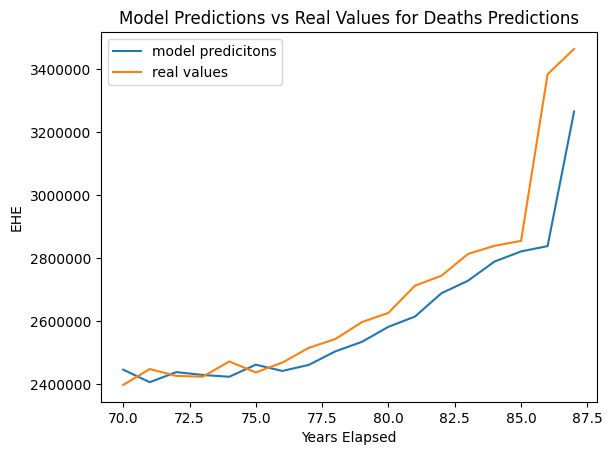

In [ ]:
#Experiment 1
#Cell is for Autoregressive  RidgeCV
#Experiment 1 uses mortality to predict mortality

from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt

days=df_merged['elapsed']

past =2
s = (len(inputs) , past  * 1)
betterinputs = np.zeros(s)
betteroutputs = np.zeros(len(inputs))

for i in range(len(inputs) - past): # - 0
  temp = np.zeros(past * 1)
  temp[0 : past] = inputs[i : i+ past]
  betterinputs[i] = temp
  betteroutputs[i] = inputs[i+past]

betterinputs = betterinputs[0:len(df_merged) - past] # - 0
betteroutputs = betteroutputs[0:len(df_merged) - past]
days = days[0:len(df_merged) - past]
print(len(days))

from matplotlib import pyplot as plt
split = int(0.8*len(betterinputs))
X_train, X_test, y_train, y_test = betterinputs[:split], betterinputs[split:], betteroutputs[:split], betteroutputs[split:]
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
days = days[split:]
print(len(days))


alphas = [0.001,0.005,0.01, 0.05]
model = RidgeCV( scoring='r2', alphas=alphas)


X_train, X_test, y_train, y_test = betterinputs[:split], betterinputs[split:], betteroutputs[:split], betteroutputs[split:]
model.fit(X_train, y_train)
print("{}".format(np.linalg.norm(model.predict(X_test) - y_test, 1)/len(y_test)))
predict = model.predict(X_test)
plt.title("Model Predictions vs Real Values for Deaths Predictions")
plt.ticklabel_format(style='plain')

print(len(days))

plt.plot( days, predict, label = "model predicitons")
plt.plot( days, y_test,  label = "real values")
plt.xlabel("Years Elapsed")
plt.ylabel("EHE")
plt.legend()
cross_val_score(model, X_train, y_train, cv = 2)

from sklearn.metrics import mean_squared_error
print(model.score(X_test, y_test))
mse = mean_squared_error(y_test, predict)
print(mse)
rmse = np.sqrt(mse)
print(rmse)

89
(89,)
18
18
18
0.7790749535301056
20313361703.11621
142524.95115984502


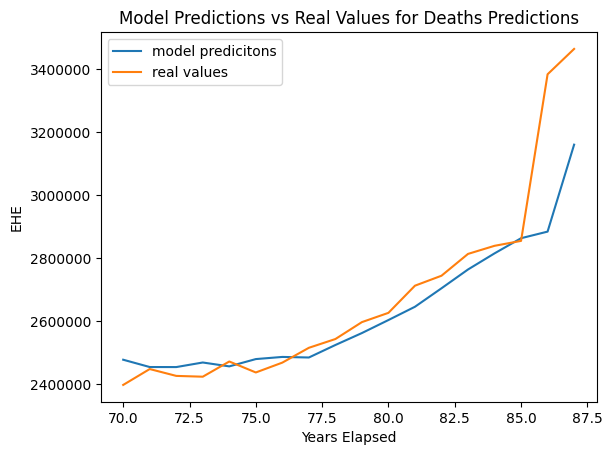

In [ ]:
#Experiment 1
#Simple Moving Avg Linear Regresison
from numpy.ma.core import mean
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression

days=df_merged['elapsed']
print(len(days))
past = 2
s = (len(inputs) ,1)
betterinputs = np.zeros(s)
betteroutputs = np.zeros(len(inputs))


for i in range (len(inputs)-past):
  temp = np.zeros(1)
  me = np.mean(inputs[i:i+past])
  temp[0] = me
  betterinputs[i] = temp
  betteroutputs[i] = inputs[i+past]


print(betteroutputs.shape)

betterinputs = betterinputs[0:len(df_merged) - past] # - 0

days = days[0:len(df_merged) - past]

betteroutputs = betteroutputs[0:len(df_merged) - past]



split = int(0.8*len(betterinputs))
X_train, X_test, y_train, y_test = betterinputs[:split], betterinputs[split:], betteroutputs[:split], betteroutputs[split:]
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
days = days[split:]





model = LinearRegression()


X_train, X_test, y_train, y_test = betterinputs[:split], betterinputs[split:], betteroutputs[:split], betteroutputs[split:]
model.fit(X_train, y_train)
print(len(X_test))
predict = model.predict(X_test)
plt.title("Model Predictions vs Real Values for Deaths Predictions")
plt.ticklabel_format(style='plain')
print(len(days))
print(len(predict))
plt.plot( days, predict, label = "model predicitons")
plt.plot( days, y_test,  label = "real values")
plt.xlabel("Years Elapsed")
plt.ylabel("EHE")
plt.legend()

print(model.score(X_test, y_test))
mse = mean_squared_error(y_test, predict)
print(mse)
rmse = np.sqrt(mse)
print(rmse)


89
87
69
1/1 [==============================] - 0s 327ms/step - loss: 11963863040.0000 - mae: 53330.4180 - mse: 11963863040.0000
[11963863040.0, 53330.41796875, 11963863040.0]
11963860835.285872
109379.4351570983
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 40)                160       
                                                                 
 dense_1 (Dense)             (None, 20)                820       
                                                                 
 dense_2 (Dense)             (None, 1)                 21        
                                                                 
Total params: 1,001
Trainable params: 1,001
Non-trainable params: 0
_________________________________________________________________
0.8698828608664312
dimensions
71    72
72    73
73    74
74    75
75    76
76    77
77    78
78    79
79 

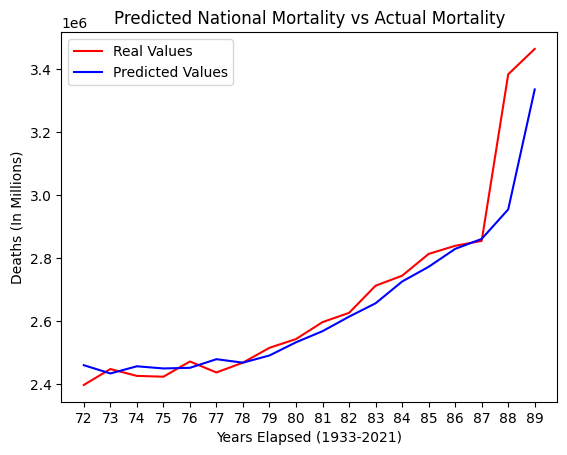

In [ ]:
#Experiment1
#This is multi Layer perceptron, Experiment 1


import random
import tensorflow as tf
from matplotlib import pyplot as plt
from numpy import hstack
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from tensorflow.keras.regularizers import l2

#seed to ensure same predictions.
seed_value = 37
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(89)




days = df_merged['elapsed']
print( len(days))

def split_sequences(sequences, n_steps):
 X, y = list(), list()
 for i in range(len(sequences)):
 # find the end of this pattern
  end_ix = i + n_steps
 # check if we are beyond the dataset
  if end_ix > len(sequences):
    break
 # gather input and output parts of the pattern
  seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
  X.append(seq_x)
  y.append(seq_y)
 return array(X), array(y)


in_seq1 = inputs

out_seq = outputs

in_seq1 = in_seq1.reshape((len(in_seq1), 1))

out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1,  out_seq))

n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)

#print (X[0:5])
#print (y[0:5])


n_input = X.shape[1] * X.shape[2]
X = X.reshape((X.shape[0], n_input))

#print (X[0:5])


# define model
model = Sequential()

model.add(Dense(40, activation='relu',  kernel_regularizer=l2(0.001),   input_dim=n_input))
model.add(Dense(20, activation='relu',  kernel_regularizer=l2(0.001),   input_dim=n_input))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error', metrics = ['mae', 'mse'])

#Test/train ratio
s_ratio = (1-0.8)
split = int(0.8*len(X))

print(len(X))

print(split)


#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = s_ratio)

X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]


# fit model
history =model.fit( X_train, y_train, epochs=100,verbose=0 )
#predict
yhat = model.predict(X_test, verbose=0)

mean_squared_error_test = model.evaluate(X_test, y_test)

print(mean_squared_error_test)
mse = mean_squared_error(y_test, yhat)
print(mse)
rmse = np.sqrt(mse)
print(rmse)

model.summary()

print(r2_score(y_test, yhat))

#plot the prediction against actual
days = days[split+2:]
print("dimensions")
print(days)
plt.xticks(range(min(days), max(days)+1))
plt.plot(days, y_test, 'red', label = 'Real Values')
plt.plot(days,  yhat,  'blue', label = 'Predicted Values')
plt.title('Predicted National Mortality vs Actual Mortality')
plt.xlabel('Years Elapsed (1933-2021)')
plt.ylabel('Deaths (In Millions)')
plt.legend()

87
18
18
0.8236722154365437
16212784034.130493
127329.43113880033


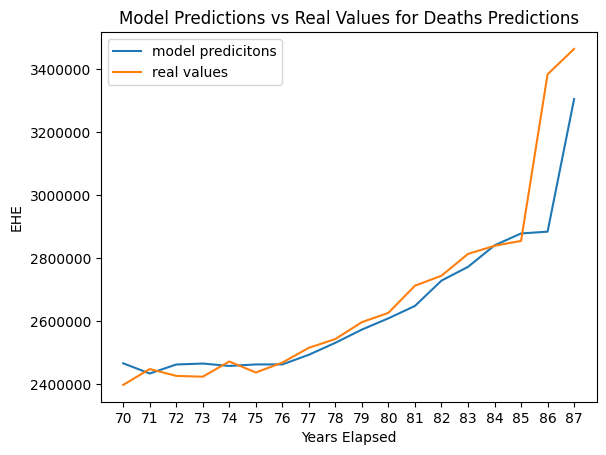

In [ ]:
#Experiment 2
#Cell is for Autoregressive Linear Regression
#Experiment 2 uses EHE and mortality to predict mortality


from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt

days=df_merged['elapsed']

past = 2
s = (len(inputs) , past *2)
betterinputs = np.zeros(s)
betteroutputs = np.zeros(len(inputs))

for i in range(len(inputs) - past): # - 0
  temp = np.zeros(past*2)
  temp[0 : past] = inputs1[i : i+ past]
  temp[past:] = outputs[i : i + past]
  betterinputs[i] = temp
  betteroutputs[i] = inputs[i+past]

betterinputs = betterinputs[0:len(df_merged) - past] # - 0
betteroutputs = betteroutputs[0:len(df_merged) - past]
days = days[0:len(df_merged) - past]
print(len(days))

from matplotlib import pyplot as plt
split = int(0.8*len(betterinputs))
X_train, X_test, y_train, y_test = betterinputs[:split], betterinputs[split:], betteroutputs[:split], betteroutputs[split:]
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
days = days[split:]
print(len(days))

model = LinearRegression()


X_train, X_test, y_train, y_test = betterinputs[:split], betterinputs[split:], betteroutputs[:split], betteroutputs[split:]
model.fit(X_train, y_train)

predict = model.predict(X_test)
plt.title("Model Predictions vs Real Values for Deaths Predictions")
plt.ticklabel_format(style='plain')

print(len(days))

plt.xticks(range(min(days), max(days)+1))
plt.plot( days, predict, label = "model predicitons")
plt.plot( days, y_test,  label = "real values")
plt.xlabel("Years Elapsed")
plt.ylabel("EHE")
plt.legend()
#cross_val_score(model, X_train, y_train, cv = 2)

from sklearn.metrics import mean_squared_error
print(model.score(X_test, y_test))
mse = mean_squared_error(y_test, predict)
print(mse)
rmse = np.sqrt(mse)
print(rmse)

87
18
[2438657.81266755 2407253.31293187 2435836.19102919 2438198.81207915
 2431164.51421944 2434929.22645957 2434657.92888063 2465374.43195431
 2501748.00857802 2541978.03774809 2575865.39169049 2613389.79050999
 2691210.73003048 2732232.90829709 2798197.29175639 2834000.14643362
 2838798.03233729 3247426.29683535]
0.7694251696970471
21200628912.017815
145604.35746232944


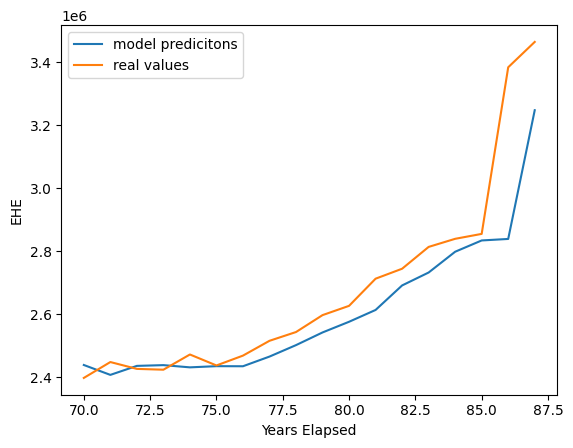

In [ ]:
#Experiment 2
#Cell is for Autoregressive RidgeCV
#Experiment 2 uses EHE and mortality to predict mortality

from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt


days=df_merged['elapsed']

past = 2
s = (len(inputs) , past *2)
betterinputs = np.zeros(s)
betteroutputs = np.zeros(len(inputs))

for i in range(len(inputs) - past): # - 0
  temp = np.zeros(past*2)
  temp[0 : past] = inputs1[i : i+ past]
  temp[past:] = outputs[i : i + past]
  betterinputs[i] = temp
  betteroutputs[i] = inputs[i+past]

betterinputs = betterinputs[0:len(df_merged) - past] # - 0
betteroutputs = betteroutputs[0:len(df_merged) - past]
days = days[0:len(df_merged) - past]
print(len(days))

from matplotlib import pyplot as plt
split = int(0.8*len(betterinputs))
X_train, X_test, y_train, y_test = betterinputs[:split], betterinputs[split:], betteroutputs[:split], betteroutputs[split:]
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
days = days[split:]
print(len(days))


alphas = [0.001,0.005,0.01]
model = RidgeCV( scoring='r2', alphas=alphas)


X_train, X_test, y_train, y_test = betterinputs[:split], betterinputs[split:], betteroutputs[:split], betteroutputs[split:]

model.fit(X_train, y_train)

predict = model.predict(X_test)
print ( predict)




plt.plot( days, predict, label = "model predicitons")
plt.plot( days, y_test,  label = "real values")
plt.xlabel("Years Elapsed")
plt.ylabel("EHE")
plt.legend()
cross_val_score(model, X_train, y_train, cv = 2)

from sklearn.metrics import mean_squared_error
print(model.score(X_test, y_test))
mse = mean_squared_error(y_test, predict)
print(mse)
rmse = np.sqrt(mse)
print(rmse)








89
(89,)
18
18
18
0.7853606975609616
19735407351.121174
140482.76531703514


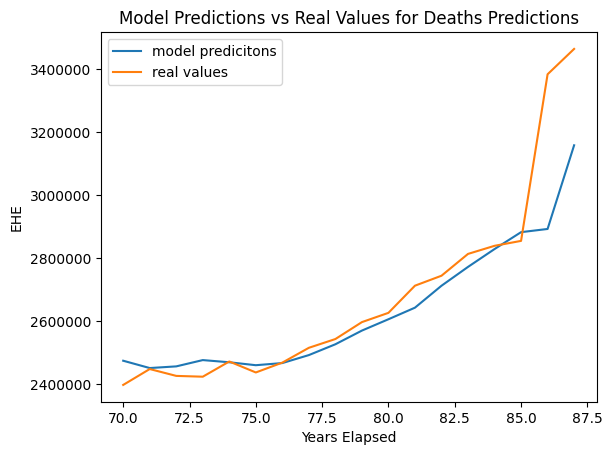

In [ ]:
#Experiment2
#Simple Moving Avg Linear Regresison, Experiment 2
from numpy.ma.core import mean
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression

days=df_merged['elapsed']
print(len(days))
past = 2
s = (len(inputs) ,2)
betterinputs = np.zeros(s)
betteroutputs = np.zeros(len(inputs))


for i in range (len(inputs)-past):
  temp = np.zeros(2)
  me = np.mean(inputs[i:i+past])
  me1=np.mean(inputs1[i:i+past])
  temp[0] = me
  temp[1] = me1
  betterinputs[i] = temp
  betteroutputs[i] = inputs[i+past]


print(betteroutputs.shape)

betterinputs = betterinputs[0:len(df_merged) - past] # - 0

days = days[0:len(df_merged) - past]

betteroutputs = betteroutputs[0:len(df_merged) - past]



split = int(0.8*len(betterinputs))


X_train, X_test, y_train, y_test = betterinputs[:split], betterinputs[split:], betteroutputs[:split], betteroutputs[split:]
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
days = days[split:]


model = LinearRegression()

X_train, X_test, y_train, y_test = betterinputs[:split], betterinputs[split:], betteroutputs[:split], betteroutputs[split:]
model.fit(X_train, y_train)
print(len(X_test))
predict = model.predict(X_test)
plt.title("Model Predictions vs Real Values for Deaths Predictions")
plt.ticklabel_format(style='plain')
print(len(days))
print(len(predict))
plt.plot( days, predict, label = "model predicitons")
plt.plot( days, y_test,  label = "real values")
plt.xlabel("Years Elapsed")
plt.ylabel("EHE")
plt.legend()

print(model.score(X_test, y_test))
mse = mean_squared_error(y_test, predict)
print(mse)
rmse = np.sqrt(mse)
print(rmse)

89
87
69
1/1 [==============================] - 0s 440ms/step - loss: 7835891712.0000 - mae: 43128.4297 - mse: 7835891712.0000
[7835891712.0, 43128.4296875, 7835891712.0]
7835890955.252262
88520.56797859051
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 40)                280       
                                                                 
 dense_4 (Dense)             (None, 20)                820       
                                                                 
 dense_5 (Dense)             (None, 1)                 21        
                                                                 
Total params: 1,121
Trainable params: 1,121
Non-trainable params: 0
_________________________________________________________________
0.9147780363130854


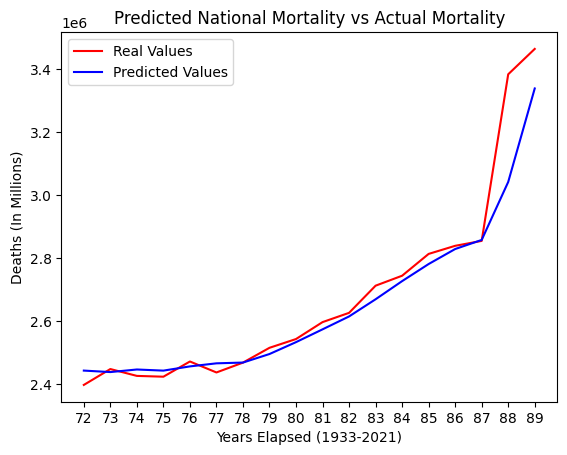

In [ ]:
#This is multi Layer perceptron experiment 2


import random
import tensorflow as tf
from matplotlib import pyplot as plt
from numpy import hstack
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from tensorflow.keras.regularizers import l2


seed_value = 37
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(89)



days = df_merged['elapsed']
print(len(days))

def split_sequences(sequences, n_steps):
 X, y = list(), list()
 for i in range(len(sequences)):
 # find the end of this pattern
  end_ix = i + n_steps
 # check if we are beyond the dataset
  if end_ix > len(sequences):
    break
 # gather input and output parts of the pattern
  seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
  X.append(seq_x)
  y.append(seq_y)
 return array(X), array(y)


in_seq1 = inputs
in_seq2 = inputs1
out_seq = outputs

#Features
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))

# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))

n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)

#print (X[0:5])
#print (y[0:5])


n_input = X.shape[1] * X.shape[2]
X = X.reshape((X.shape[0], n_input))

print ( len(X))
#print (X[0:5])


# define model
model = Sequential()

model.add(Dense(40, activation='relu',  kernel_regularizer=l2(0.001),   input_dim=n_input))
model.add(Dense(20, activation='relu',  kernel_regularizer=l2(0.001),   input_dim=n_input))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error', metrics = ['mae', 'mse'])

#test/train ratio
s_ratio = (1-0.8)
split = int(0.8*len(X))
print( split)

X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]

# fit model
history =model.fit( X_train, y_train, epochs=100,verbose=0 )

#predict
yhat = model.predict(X_test, verbose=0)

mean_squared_error_test = model.evaluate(X_test, y_test)

print(mean_squared_error_test)
mse = mean_squared_error(y_test, yhat)
print(mse)
rmse = np.sqrt(mse)
print(rmse)

model.summary()





print(r2_score(y_test, yhat))

#plot the prediction against actual
days = days[split+2:]

plt.xticks(range(min(days), max(days)+1))
plt.plot(days, y_test, 'red', label = 'Real Values')
plt.plot(days,  yhat,  'blue', label = 'Predicted Values')
plt.title('Predicted National Mortality vs Actual Mortality')
plt.xlabel('Years Elapsed (1933-2021)')
plt.ylabel('Deaths (In Millions)')
plt.legend()





                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                     1908.
Date:                Fri, 04 Aug 2023   Prob (F-statistic):           3.96e-77
Time:                        16:05:08   Log-Likelihood:                 190.61
No. Observations:                  88   AIC:                            -373.2
Df Residuals:                      84   BIC:                            -363.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.6649      0.047    288.392      0.0

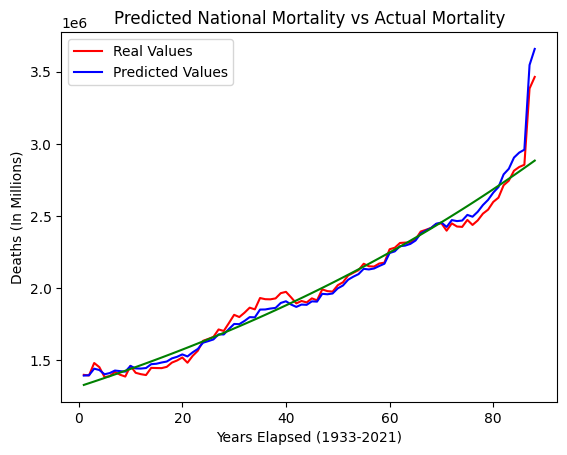

In [ ]:
 #Exponential Regression ( both experiment 1 and experiment 2 here)
import statsmodels.api as sm

days=df_merged['elapsed']

past = 1
s = (len(inputs) , 4 )
betterinputs = np.zeros(s)
betteroutputs = np.zeros(len(inputs))


#Experiment 2 ( mortality + EHE)
for i in range(len(inputs) - past ): # - 0
  temp = np.zeros(4)
  temp[0 : 1 ]= days[i]
  temp[1: ] = inputs[i]
  #temp[2: ] = inputs3[i]
  temp[2: ] = inputs1[i]
  betterinputs[i] = temp
  betteroutputs[i] = inputs[i+past]

betterinputs = betterinputs[0:len(df_merged)-past] # - 0
betteroutputs = betteroutputs[0:len(df_merged)-past]
days = days[0:len(df_merged)-past]

log_deaths = np.log(betteroutputs)
X = betterinputs
X = sm.add_constant(X)
y = log_deaths
mod = sm.OLS(y, X)
res = mod.fit()
print(res.summary())
c = res.params[0]
b = res.params[1]
d = res.params[2]
f = res.params[3]
#f = res.params[4]


#predictions = np.exp(c) * np.exp(b) ** days * np.exp(d) ** inputs[1:]* np.exp(e) ** inputs3[1:]* np.exp(f) ** inputs1[1:]
predictions = np.exp(c) * np.exp(b) ** days * np.exp(d) ** inputs[1:]* np.exp(f) ** inputs1[1:]
days=df_merged['elapsed']
past = 1
s = (len(inputs),1)
betterinputs = np.zeros(s)
betteroutputs = np.zeros(len(inputs))


#Experiment 1  mortality only)
for i in range(len(inputs)-past): # - 0
  temp = np.zeros(1)
  temp[:1 ] = inputs[i]
  betterinputs[i] = temp
  betteroutputs[i] = inputs[i+past]

betterinputs = betterinputs[0:len(df_merged)-past] # - 0
betteroutputs = betteroutputs[0:len(df_merged)-past]
days = days[0:len(df_merged)-past]

log_deaths= np.log(betteroutputs)
X = days
X = sm.add_constant(X)
y = log_deaths
mod = sm.OLS(y, X)
res = mod.fit()
print(res.summary())
c = res.params[0]
b = res.params[1]


predictions1 = np.exp(c) * np.exp(b) ** days

res.params

plt.plot(days, betteroutputs, 'red', label = 'Real Values')
plt.plot(days, predictions,  'blue', label = 'Predicted Values')
plt.plot(days, predictions1,  'green')

plt.title('Predicted National Mortality vs Actual Mortality')
plt.xlabel('Years Elapsed (1933-2021)')
plt.ylabel('Deaths (In Millions)')
plt.legend()

print(c)
print(b)